# Use the MRP to explore the relation between halo mass and stellar mass

In this example, we'll use the MRP function for something other than pure halo mass functions. We'll use it to find the subhalo abundance-matched (SHAM) stellar-mass halo-mass relation (i.e. how much stellar mass does a halo of mass *m* typically contain?).

This can be done purely numerically, but we'll show (as per section 5 of the MRP paper) that using the analytic nature of the MRP means we can do slightly better than pure numerics.

**Plots from this example appear in MRP as figures 14, 15**

## Motivation and numerical solution

The SHAM approximation for calculating the relationship between stellar and halo mass is simply to equate the cumulative number densities at every mass:

$$ n_g(>m_\star) = n_h(>m_h). $$

The galaxy stellar mass function (GSMF) is commonly parameterised as a double-Schechter function, which has the integral

$$ n_g(>m_\star) = \Phi_1 \Gamma\left(\alpha_1 + 1, \frac{m_\star}{M_\star}\right) + \Phi_2 \Gamma\left(\alpha_2 + 1, \frac{m_\star}{M_\star}\right), $$

which when equated to the MRP gives us the following equation to solve:

$$ A \mathcal{H_\star} \Gamma(z_h, x_h) = \Phi_1 \Gamma\left(\alpha_1 + 1, \frac{m_\star}{M_\star}\right) + \Phi_2 \Gamma\left(\alpha_2 + 1, \frac{m_\star}{M_\star}\right), $$

where we use the common definitions from the MRP paper: $z_h = (\alpha_h + 1)/\beta$ and $x_h = (m_h/\mathcal{H}_\star)^\beta$.

**NOTE: the *subhalo* mass function is to be used here, since it is the subhalos which contain galaxies. The MRP is quite able to fit the sHMF as well.**

So, we'd hope we could just go and solve this equation for $m_\star$ as a function of $x_h$. However, unfortunately, the solution is analytically impossible (though maybe you could try?).

The first idea then would be to solve it purely numerically, which is what we're going to do in this section.

First, some general imports and parameters:


In [4]:
# Some imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mrpy.extra.physical_dependence import mrp_params_b13
from mrpy import MRP
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.optimize import newton, curve_fit
from mpmath import gammainc, log, exp

In [5]:
# Some parameters
z = 0
H0 = 67.04
mhalo = np.linspace(9,15.5,200) # vector of halo masses to plot.

Now define the MRP explicitly, based on best parameters for z=0

In [6]:
# Get relevant MRP parameters at z=0 for Planck cosmology
(logHs,alpha,beta,lnA) = mrp_params_b13(z=0)

# Create an MRP instance with those params
mrp = MRP(mhalo,logHs,alpha,beta,norm=lnA)

We'll also want to define the GSMF explicitly. We use the data from Baldry+12 to define it:

In [7]:
# Parameters (Baldry+12 defines densities in H0=100 units and masses in H0=70.0 units)
logMs=10.66 + np.log10(0.7) + np.log10(70.0/H0)
alpha1=-0.35
log_phi1=-2.402+3*np.log10(100./H0)
alpha2=-1.47
log_phi2=-3.1+3*np.log10(100./H0)

# One way to define a double-schechter function is to add two MRP's with beta=1:
def ngtm_dblschech(m,logMs,alpha1,log_phi1,alpha2,log_phi2):
    schech1 = MRP(m,logMs,alpha1,1.0,norm=np.log(10)*(log_phi1 - logMs))
    schech2 = MRP(m,logMs,alpha2,1.0,norm=np.log(10)*(log_phi2 - logMs))

    return schech1.ngtm() + schech2.ngtm()

# The GMSF
ngtm_baldry = ngtm_dblschech(mhalo,logMs,alpha1,log_phi1,alpha2,log_phi2)

Now that we have the left-hand and right hand sides, we can solve. 

The basic idea is to find which mass in the GSMF has the same value for its $n(>m_\star)$ as a particular mass in the MRP. You can think of this as plotting the two functions together, and then drawing horizontal arrow from one to the other (see below!).

The obvious way to do this is by using splines, and that is the best way to think about it. However, numerically, this is pretty non-robust, since then the GSMF has to be calculated over a range which covers the whole HMF, before we know what that range is. 

We rather do this calculation by root-finding. So we write a function which generally solves the double schechter function for $x$ given an output $q$. Then we relate this to our actual problem. For the root-finding, we use the ``gammainc`` function straight from ``mpmath``, since we need to retain as much precision as possible, to enlarge the mass range within which this works. Also, to get more reliability, we implement an analytic derivative.

In [8]:
def inv_inc_gamma_dbl(a1,a2,n1,n2,q,x0=0):
    """
    Returns x for q = n1*Gamma(a1,x)+n2*Gamma(a2,x).

    This is general, so supports a<0, but is slow, uses root finding to generate
    the solution.
    """

    def obj_func(x):

        x=np.exp(x)
        p1 = n1*gammainc(a1,x)
        p2 = n2*gammainc(a2,x)
        rat = float(p1/p2)

        if rat>5:
            func = float(log(p1) + np.log1p(1/rat) - log(q))
        elif rat<0.2:
            func = float(log(p2) + np.log1p(rat) - log(q))
        else:
            func = float(log(p1+p2) - log(q))

        return func#,fprime#,fprime2

    def fprime(x):
        x=np.exp(x)
        p1 = n1*gammainc(a1,x)
        p2 = n2*gammainc(a2,x)

        bottom = (p1+p2)
        top = n1*x**a1 + n2*x**a2
        y = exp(-x)
        fprime = -float(y*top/(bottom))

        return fprime
    
    res = newton(obj_func,x0=x0,fprime=fprime)#,fprime2=True)
    return np.exp(res)

def mh_to_ms_schech(log_mh,ngtm,logMs,alpha1,log_phi1,alpha2,log_phi2):
    """
    Generate the SMHM relation ms(mh) for a black-box mass function and single or
    double Schechter SMF.

    Parameters
    ----------
    log_mh : array_like
        log10 halo masses

    ngtm : array_like
        Cumulative mass function.

    Ms, alpha1, alpha2, log_phi1, log_phi2 : float
        Double-schechter parameters. log_phi is in log10.

    Returns
    -------
    ms : array_like
        The log10 stellar masses corresponding to mh.
    """
    # Make sure mh is an array 
    log_mh = np.atleast_1d(log_mh)
    
    ms = np.zeros_like(log_mh)
    for i,ng in enumerate(ngtm):
        ms[i] = inv_inc_gamma_dbl(alpha1+1,alpha2+1,10**log_phi1,10**log_phi2,ng,x0=ms[min(i-1,0)])

    return np.log10(ms)+logMs


Finally we write a convenience function that calculates the transform from mhalo to mstar in both directions, and also from either to the fraction mstar/mhalo.

In [9]:
def get_all_relations(log_mhalo, mrp, **gsmf_kwargs):
    ms = mh_to_ms_schech(log_mhalo, mrp, **gsmf_kwargs)
    
    ms_to_mh = lambda sm : spline(ms,log_mhalo)(sm)
    mh_to_ms = spline(log_mhalo,ms)
    ms_to_frac = spline(ms,10**(ms-log_mhalo))
    mh_to_frac = spline(log_mhalo,10**(ms-log_mhalo))
    return ms_to_mh, mh_to_ms,ms_to_frac,mh_to_frac

In [10]:
mstar_to_mhalo, mhalo_to_mstar, mstar_to_frac, mhalo_to_frac = get_all_relations(mhalo, mrp.ngtm(), 
                                                                                 alpha1=alpha1,logMs=logMs,log_phi1=log_phi1,
                                                                                alpha2=alpha2,log_phi2=log_phi2)

And we can make a plot. We'll make a two-panel plot with the upper panel showing the schematic of what we're doing, and the bottom showing the numerical result.

/home/steven/miniconda3/envs/mrpy/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


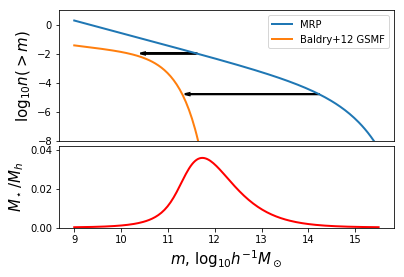

In [11]:
# Set up the basic figure with two subplots (one will be blank for now)
fig,ax= plt.subplots(2,1,gridspec_kw={"height_ratios":(1.6,1)})

# Plot both n(>m)
ax[0].plot(mhalo,np.log10(mrp.ngtm()),label="MRP",lw=2)
ax[0].plot(mhalo,np.log10(ngtm_baldry),label="Baldry+12 GSMF",lw=2)

# Axis stylings
ax[0].legend(loc=0)
ax[0].set_ylim((-8,1))
ax[0].set_ylabel(r"$\log_{10} n(>m)$",fontsize=15)

# Here we want to draw horizontal arrows connecting the MRP to the GSMF.
# These will signify the masses of each that have the same value of n(>m), i.e., the SMHM relation.
n1 = int(len(mhalo)*2.0/5.0)
dx1 = np.log10(mhalo_to_frac(mhalo[n1])) + 0.355
ax[0].arrow(mhalo[n1],np.log10(mrp.ngtm()[n1]),dx1,0,head_width=0.15,head_length=0.1,lw=2)

n2 = int(len(mhalo)*4.0/5.0)
dx2 = np.log10(mhalo_to_frac(mhalo[n2])) + 0.155
ax[0].arrow(mhalo[n2],np.log10(mrp.ngtm()[n2]),dx2,0,head_width=0.15,head_length=0.1,lw=2)


# Now plot the actual SMHM relation in the bottom panel
ax[1].plot(mhalo,mhalo_to_frac(mhalo),color="r",lw=2)

# Bottom axis stylings
ax[0].xaxis.set_ticks([])
ax[1].set_ylabel(r"$M_\star/M_h$",fontsize=15)
ax[1].set_xlabel(r"$m$, $\log_{10}h^{-1}M_\odot$",fontsize=15)
ax[1].set_ylim((0,0.042))
plt.subplots_adjust(hspace=0.05)


# Save for the paper!
fig.savefig("../../../mrpArticle/figures/numerical_solution.pdf")


## Empirical Models from Literature

There are several models in the literature which attempt to parameterise the ratio $m_star/m_h$ (i.e. to fit the red curve above). In this section, we'll define three of those, and show how they stack up to our numerical solution.

In this case all we really need is the conversion from $m_h$ to the fraction, $f = m_star/m_h$. We'll take the models of Moster+09, Mutch+13 and Behroozi+10:

In [12]:
## Moster+09 (default arguments are those given in the paper)
def mh_to_frac_moster(mh,f0=0.0282,m1=11.884,beta=1.057,gamma=0.556):
    return 2*f0/(10**(-beta*(mh-m1)) +10**(gamma*(mh-m1)))

## Mutch+13
def mh_to_frac_mutch(mh,eps=0.17*0.9,mpeak=11.6,sigma=0.56):
    return  eps * np.exp(-(mh-mpeak)**2/sigma**2)


## Behroozi+10 -- this is a bit more complicated since Behroozi defines m_h(m_s) rather than the other way around.
def ms_to_mh_behroozi(ms,m1=10.72,m1_a=0.55,m0=12.35,m0_a=0.28,beta=0.44,
                      beta_a=0.18,delta=0.57,delta_a=0.17,gamma=1.56,gamma_a=2.51,
                      z=0):
    # Get evolution of parameters
    a=1./(1.+z)
    m1 += m1_a*(a-1)
    m0 += m0_a*(a-1)
    beta += beta_a*(a-1)
    delta += delta_a*(a-1)
    gamma += gamma_a*(a-1)

    logx = ms - m1
    x = 10**logx
    return m0 + beta*logx + x**delta/(1+x**-gamma) - 0.5

def mh_to_ms_func_behroozi(**kwargs):
    ms = np.linspace(6,13,1000)
    mh = ms_to_mh_behroozi(ms,**kwargs)
    return spline(mh,ms)

def mh_to_frac_behroozi(mh,**kwargs):
    msfunc = mh_to_ms_func_behroozi(**kwargs)
    return 10**(msfunc(mh)-mh)


With these defined, we can fit their parameters to our numerical solution, since in this case we care more about how the model itself performs, rather than the actual values of the parameters. To do this, we just use a simple curve_fit method. We perform the fit in log-log space, since that performs the best over a large mass range.

In [13]:
# Log of the numerical solution
logf = np.log(mhalo_to_frac(mhalo))

# ---------- MOSTER --------------------------------------------------
# Define an objective function to minimize for Moster+09
def moster_obj_func(mh, *args) : 
    return np.log(mh_to_frac_moster(mh,*args))

# Minimize the function
moster_res = curve_fit(moster_obj_func,mhalo,logf,p0=(0.0282,11.884,1.057,0.556))[0]

# ---------- MUTCH --------------------------------------------------
# Define an objective function to minimize for Moster+09
def mutch_obj_func(mh, *args) : 
    return np.log(mh_to_frac_mutch(mh,*args))

# Minimize the function
mutch_res = curve_fit(mutch_obj_func,mhalo,logf,p0=(0.15,11.6,0.56))[0]


# ---------- BEHROOZI --------------------------------------------------
# Define an objective function to minimize for Moster+09
def behroozi_obj_func(mh,m0,m1,beta,delta,gamma) : 
    return np.log(mh_to_frac_behroozi(mh,m0=m0,m1=m1,beta=beta,delta=delta,gamma=gamma))

# Minimize the function
behroozi_res = curve_fit(behroozi_obj_func,mhalo,logf,p0=(12.35,10.72,0.44,0.57,1.56))[0]

/home/steven/miniconda3/envs/mrpy/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log


Now plot the solutions against the numerical result:

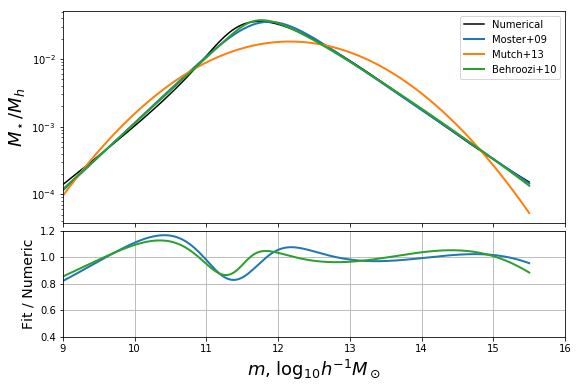

In [14]:
def plotbase():
    fig,ax = plt.subplots(2,1,sharex=True,gridspec_kw={"height_ratios":(2,1)},figsize=(9,6))

    ax[0].plot(mhalo,mhalo_to_frac(mhalo),label="Numerical",color="k")

    # Plot Moster results
    ax[0].plot(mhalo,mh_to_frac_moster(mhalo,*moster_res),label="Moster+09",color="C0",lw=2)
    ax[1].plot(mhalo,mh_to_frac_moster(mhalo,*moster_res)/mhalo_to_frac(mhalo),color="C0",lw=2)

    # Plot Mutch results
    ax[0].plot(mhalo,mh_to_frac_mutch(mhalo,*mutch_res),label="Mutch+13",color="C1",lw=2)

    # Plot Behroozi Results
    ax[0].plot(mhalo,np.exp(behroozi_obj_func(mhalo,*behroozi_res)),label="Behroozi+10",color="C2",lw=2)
    ax[1].plot(mhalo,np.exp(behroozi_obj_func(mhalo,*behroozi_res))/mhalo_to_frac(mhalo),color="C2",lw=2)

    # Plot Stylings
    ax[0].legend(loc=0)
    ax[0].set_yscale('log')
    ax[1].set_ylim((0.4,1.2))
    ax[0].set_xlim((9,16))
    ax[1].grid(True)
    ax[0].set_ylabel(r"$M_\star/M_h$",fontsize=18)
    ax[1].set_ylabel("Fit / Numeric",fontsize=14)
    ax[1].set_xlabel(r"$m$, $\log_{10}h^{-1}M_\odot$",fontsize=18)
    plt.subplots_adjust(hspace=0.05)
    return fig,ax
fig,ax = plotbase()

### Constraining Parameters via Analytic Limits

We now investigate the behaviour of the parameterisations based on what we can learn from analytic approximations to the solution. Though we cannot solve the full equation analytically for all $m_h$, we do well to identify its behaviour in the limits. 

As $x \rightarrow 0$, we have the identity $\Gamma(z,x) \rightarrow -x^z/z$, for $z<0$. The speed of convergence of this limit depends heavily on the value of $z$ (the more negative, the faster the convergence). 

In this case, at small mass, the $\alpha_2$ term dominates the $\alpha_1$ term (which generally has positive shape parameter), so we can simply write

$$	-\frac{\Phi_2\left(\frac{m_\star}{M_\star}\right)^{(\alpha_2 + 1)} }{\alpha_2 + 1} = -\frac{A \mathcal{H}_\star x_h^{z_h}}{z_h}, $$

so that we find that the ratio is a power law:

\begin{align}
	\frac{m_\star}{m_h} &= K m_h^p, \\
	p &= \frac{\alpha_h-\alpha_2}{\alpha_2+1} \\
	K &= M_\star \mathcal{H}_\star^{-\frac{\alpha_h}{\alpha_2+1}} \left(\frac{A (\alpha_2+1)}{\Phi_2 z_h}\right)^{\frac{1}{\alpha_2+1}},
\end{align}

While M13 cannot replicate this behaviour in the low-mass limit, both M09 and B10 can. Specifically, M09 is equivalent in the low-mass limit if $\beta = p$ and $2 f_0/m_1^p = K$, while B10 requires $\beta = 1/(p+1)$ and $m_1 (\sqrt{10}/m_0)^{1/\beta} = K$.

Let's write a function to get these constants of the low-mass limit:

In [15]:
def set_lowmass_const(alpha_num,alpha_den, Ms_num,Ms_den,norm_num,norm_den,
                      beta_num,beta_den):
    """
    Sets p, K for analytic approximation of low-mass relationship.

    Parameters
    ----------
    alpha_num, alpha_den : float
        slopes of the numerator and denominator mass functions respectively
        (eg. for SMHM, this would alpha_smf, and alpha_hmf).

    Ms_num, Ms_den : float
        Characteristic log10 masses of numerator and denominator mf's.
        (eg. for SMHM, this would be Ms, Hs)

    norm_num, norm_den : float
        Normalisation of numerator and denominator mf's.
        (eg. for SMHM, this would be phi, A*10^Hs)

    beta_num, beta_den : float
        Cut-off parameter for num and den mf's.
        (eg. for SMHM, this would be 1, beta)
    """
    z_num = (alpha_num + 1)/beta_num
    z_den = (alpha_den + 1)/beta_den
    p = (alpha_den-alpha_num)/z_num
    scale = 10**(Ms_num-Ms_den)
    z_rat = z_num/z_den
    N = norm_den/norm_num
    K = scale * (N * z_rat)**(1.0/z_num)*10**(-Ms_den*p)

    return p,K

In [16]:
# Actually set the p,K in our case
p,K = set_lowmass_const(alpha2,alpha, logMs,logHs,10**log_phi2,np.exp(lnA)*10**logHs,1.0,beta)

Now we can re-write our objective functions for Moster+09 and Behroozi+10 so that their constants are set by the low-mass behaviour, and rederive solutions.

In [17]:
def moster_fixed_obj_func(mh,m1,gamma):
    f0 = 10**(m1*p) * K/2
    beta = p
    return np.log(mh_to_frac_moster(mh,f0,m1,beta,gamma))

moster_fixed_res = curve_fit(moster_fixed_obj_func,mhalo,logf,p0=(11.884,0.6))[0]

def behroozi_fixed_obj_func(mh,m0,delta,gamma):
    beta = 1./(p+1)
    m1 = np.log10(K) + (m0-0.5)/beta
    return np.log(mh_to_frac_behroozi(mh,m1=m1,m0=m0,beta=beta,delta=delta,gamma=gamma))

behroozi_fixed_res = curve_fit(behroozi_fixed_obj_func,mhalo,logf,p0=(12.35,0.57,1.56))[0]

Plot the solutions along with the plot from before. For some reason in the notebook the figures get closed after every cell so we have to recall the earlier plot.

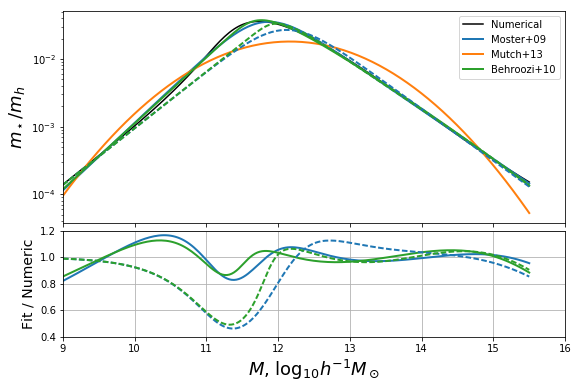

In [23]:
fig,ax = plotbase()

def fixed_additions():
    ax[0].plot(mhalo,np.exp(moster_fixed_obj_func(mhalo,*moster_fixed_res)),color="C0",ls='--',lw=2)
    ax[1].plot(mhalo,np.exp(moster_fixed_obj_func(mhalo,*moster_fixed_res))/mhalo_to_frac(mhalo),color="C0",ls="--",lw=2)

    ax[0].plot(mhalo,np.exp(behroozi_fixed_obj_func(mhalo,*behroozi_fixed_res)),color="C2",ls="--",lw=2)
    ax[1].plot(mhalo,np.exp(behroozi_fixed_obj_func(mhalo,*behroozi_fixed_res))/mhalo_to_frac(mhalo),color="C2",ls="--",lw=2)
    
    # add label to fig
    ax[0].plot([0],[0],color='k',ls='--',label="Fixed low-mass")
    return fig, ax

fig,ax = fixed_additions()

We can see clearly that the asymptotic behaviour at low mass for the dashed curves we just added tends towards unity. 

## Defining our own extended model

The most severe deficiency of both models, and this is exacerbated by correctly setting the low-mass behaviour, is the position of the turning point. A simple way to change the position of the turning point without affecting the behaviour in the limits, is to use an extension of M09:

\begin{equation}
	\frac{m_\star}{m_h} = \frac{w\left(\frac{m_h}{m_1}\right)^{-\delta} + 2 f_0}{\left(\frac{m_h}{m_1}\right)^{-\beta} + w\left(\frac{m_h}{m_1}\right)^{\gamma} + k},
\end{equation}

where $w$ controls the peak position, $k$ is able to correct the amplitude of the high-mass power-law, and $\delta$ adds the flexibility needed to induce an upturn left of the turning point. This extension obeys the same relations as M09 in terms of the low-mass approximation, but has the difference that the high-mass power law has the slope $\delta-\gamma$. 

We can define this function, and its objective function for optimization:

In [18]:
def mh_to_frac_triple_pl(mh,f0=0.0282,m1=11.884,beta=1.057,gamma=0.556,delta=0,k=0,w=1):
    return (10**(w*delta*(mh-m1)) +2*f0)/(10**(-beta*(mh-m1)) +w*10**(gamma*(mh-m1))+k)

def triple_pl_obj_func( mh,m1,gamma,delta,k,w):
    f0 = 10**(m1*p) * K/2
    beta = p
    return np.log(mh_to_frac_triple_pl(mhalo,f0,m1,beta,gamma,delta,k,w))

triple_pl_res = curve_fit(triple_pl_obj_func,mhalo,logf,p0=(11.884,2.6,2,1,1))

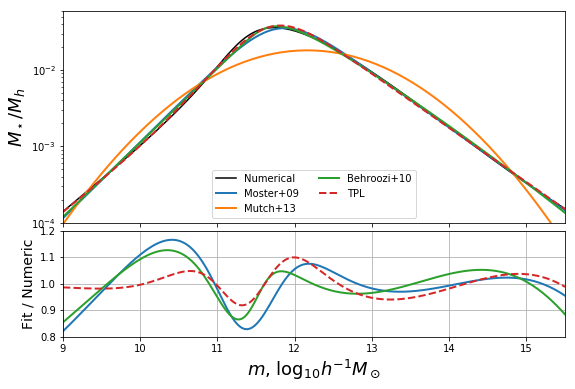

In [21]:
fig,ax = plotbase()
#fig,ax = fixed_additions()

ax[0].plot(mhalo,np.exp(triple_pl_obj_func(mhalo,*triple_pl_res[0])),label="TPL",color="C3",ls='--',lw=2)
ax[1].plot(mhalo,np.exp(triple_pl_obj_func(mhalo,*triple_pl_res[0]))/mhalo_to_frac(mhalo),color="C3",ls="--",lw=2)
ax[0].legend(loc=0,ncol=2)

ax[0].set_ylim((1e-4,0.06))
ax[0].set_xlim((9,15.5))
ax[1].set_ylim(0.8,1.2)
# Save for the paper!
fig.savefig("../../../mrpArticle/figures/compare_mine_fixed.pdf")